In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import random
import os
#import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics

from sklearn.decomposition import PCA
from utils.custom_loss_class import CPHSLoss
from utils.custom_loss_class2 import CPHSLoss2
import matplotlib.pyplot as plt

from torch_linregr import cost_l2_torch, full_train_linregr_updates

In [2]:
import time
import pickle
from math import isnan

In [3]:
#class CPHSLoss(torch.nn.modules.loss._Loss):
#def __init__(self, F, D, V, learning_batch, lambdaF=0, lambdaD=1e-3, lambdaE=1e-6, Nd=2, Ne=64, return_cost_func_comps=False, verbose=False, dt=1/60, normalize_V=False) -> None:
#def forward(self, outputs, targets, my_model):

#self.loss = CPHSLoss(self.F, self.model.weight, self.V, self.F.size()[1], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=self.return_cost_func_comps)
#loss_value.backward()

In [4]:
# CLIENTBASE.PY
#self.loss = CPHSLoss(self.F, self.model.weight, self.V, self.F.size()[1], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=self.return_cost_func_comps)
#
#self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
#self.learning_rate_scheduler = torch.optim.lr_scheduler.ExponentialLR(
#    optimizer=self.optimizer, 
#    gamma=args.learning_rate_decay_gamma
#)
#self.learning_rate_decay = args.learning_rate_decay

In [5]:
# CLIENTAVG.PY
#output = self.model(x)
#loss = self.loss(output, y, self.model)
#self.loss_log.append(loss.item())
#running_num_samples += x.size(0)
#self.optimizer.zero_grad()
#loss.backward()
#self.optimizer.step()

In [6]:
# TORCH_LINREGR.PY
# TRAIN MODEL
# reset gradient so it doesn't accumulate
#optimizer.zero_grad()
# forward pass and loss
#y_pred = model(torch.transpose(emg_streamed_batch, 0, 1))  # Why do I have to transpose again here... my original code didn't
# F, D, V, learning_batch
#if use_CPHSLoss:
#    criterion = CPHSLoss
#else:
#    criterion = cost_l2_torch
#loss = criterion(emg_streamed_batch, model.weight, V, emg_streamed_batch.shape[1], Ne=PCA_comps, lambdaF=lambdasFDE[0], lambdaD=lambdasFDE[1], lambdaE=lambdasFDE[2])  #, return_cost_func_comps=return_cost_func_comps)
# backward pass
#loss.backward(retain_graph=True)
# update weights
#optimizer.step()

# Load In Data And Params

In [7]:
with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)
    
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

# Testing Basic PyTorch and SKLearn Linear Regression

## From NB106

In [8]:
# Functioning params from NB101-106
lambdaF = 0
lambdaD = 1e-10
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]
learning_rate = 0.0001

dt=1/60

#train/test split at update_ix[16]
cli0_cond1_traindata = torch.from_numpy(emgs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_trainlabels = torch.from_numpy(refs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_testdata = torch.from_numpy(emgs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)
cli0_cond1_testlabels = torch.from_numpy(refs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)

lower_bound = update_ix[10]
upper_bound = update_ix[11]
#s_temp = cli0_cond1_traindata[lower_bound:upper_bound]
#p_reference = torch.transpose(cli0_cond1_trainlabels[lower_bound:upper_bound], 0, 1)

## Using CPHSLoss

In [9]:
cli0_cond1_traindata.shape

torch.Size([19230, 64])

In [10]:
cli0_cond1_trainlabels.shape

torch.Size([19230, 2])

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True; use_CPHSLoss2 False
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data True
stream_data_updates False
return_cost_func_comps False


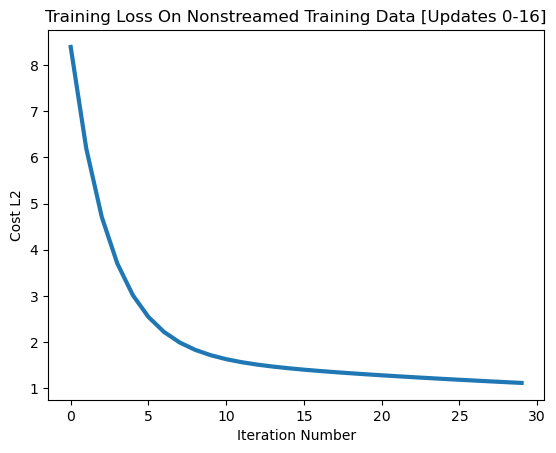

In [11]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

#train/test split at update_ix[16]
cli0_cond1_traindata = torch.from_numpy(emgs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_trainlabels = torch.from_numpy(refs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_testdata = torch.from_numpy(emgs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)
cli0_cond1_testlabels = torch.from_numpy(refs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)

#def full_train_linregr_updates(model, full_trial_input_data, full_trial_labels, 
#    learning_rate, lambdasFDE=[0, 1e-3, 1e-6], use_CPHSLoss=False, normalize_data=False, PCA_comps=64, 
#    num_iters_per_update=30, starting_update=10, use_full_input_data=False, stream_data_updates=True, 
#    dt=1/60, loss_log=None, verbose=False, verbose_norms=False, return_cost_func_comps=False, update_ix=...):
trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True; use_CPHSLoss2 False
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


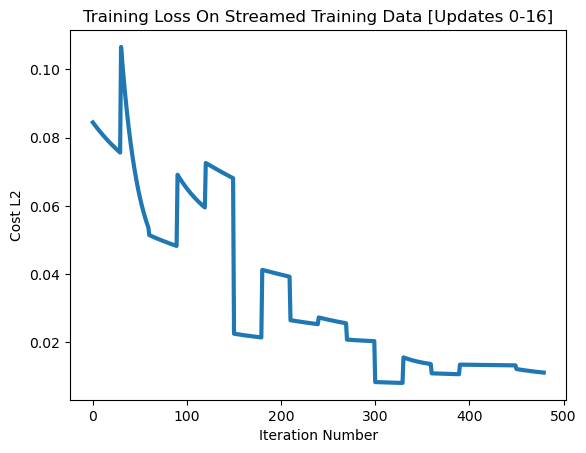

In [12]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss True; use_CPHSLoss2 False
normalize_emg False
num_iters_per_update 30
starting_update 10
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


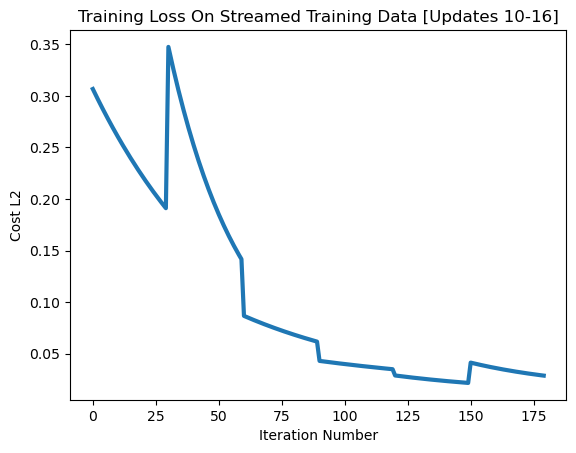

In [13]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed10, loss_log_streamed10 = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=10,
                                                                       use_CPHSLoss=True)

plt.plot(range(len(loss_log_streamed10)), loss_log_streamed10, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 10-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Using CPHLoss2

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data True
stream_data_updates False
return_cost_func_comps False


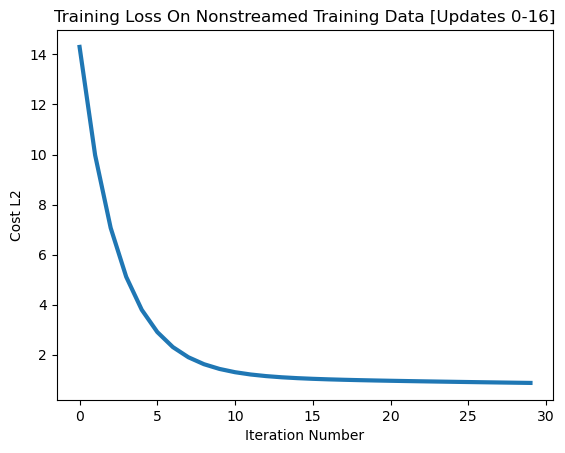

In [14]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

#train/test split at update_ix[16]
cli0_cond1_traindata = torch.from_numpy(emgs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_trainlabels = torch.from_numpy(refs_block1[keys[0]][0, :update_ix[16], :]).type(torch.float32)
cli0_cond1_testdata = torch.from_numpy(emgs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)
cli0_cond1_testlabels = torch.from_numpy(refs_block1[keys[0]][0, update_ix[16]:, :]).type(torch.float32)

#def full_train_linregr_updates(model, full_trial_input_data, full_trial_labels, 
#    learning_rate, lambdasFDE=[0, 1e-3, 1e-6], use_CPHSLoss=False, normalize_data=False, PCA_comps=64, 
#    num_iters_per_update=30, starting_update=10, use_full_input_data=False, stream_data_updates=True, 
#    dt=1/60, loss_log=None, verbose=False, verbose_norms=False, return_cost_func_comps=False, update_ix=...):
trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


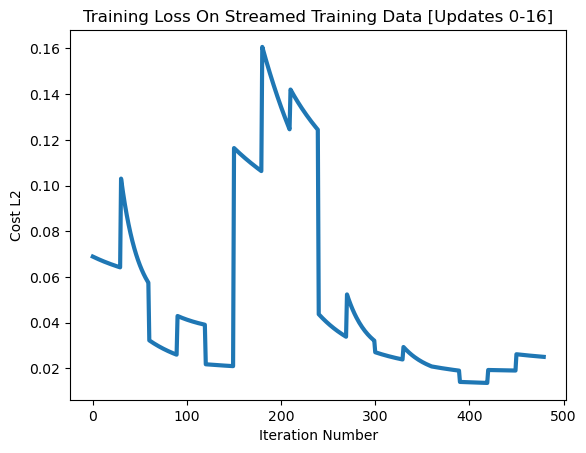

In [15]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 10
use_full_input_data False
stream_data_updates True
return_cost_func_comps False


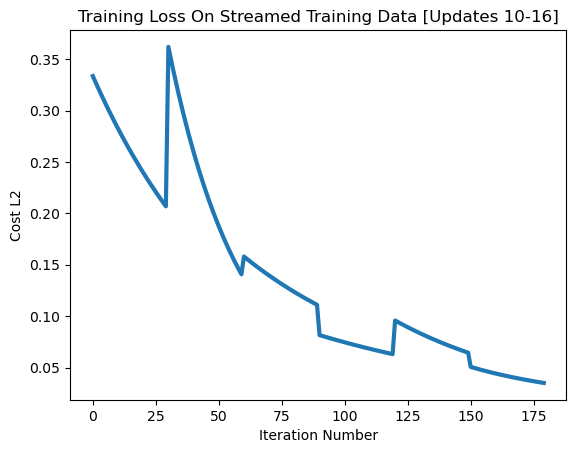

In [16]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed10, loss_log_streamed10 = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=10,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_streamed10)), loss_log_streamed10, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 10-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Comparing Model and Matmul

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data True
stream_data_updates False
return_cost_func_comps False

v_pred_model shape: torch.Size([19228, 2]);
 vals[:5,:]: tensor([[-0.0926, -0.0384],
        [-0.0926, -0.0384],
        [-0.0926, -0.0384],
        [ 4.1242,  1.8329],
        [ 4.1242,  1.8329]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[11.1172, 18.5797],
        [11.1172, 18.5797],
        [11.1172, 18.5797],
        [13.0092, 15.6251],
        [13.0092, 15.6251]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([19228, 2]);
 vals[:5,:]: tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [4.2168, 1.8713],
        [4.2168, 1.8713]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[11.2098, 18.6181],
        [11.2098, 18.6181],
 

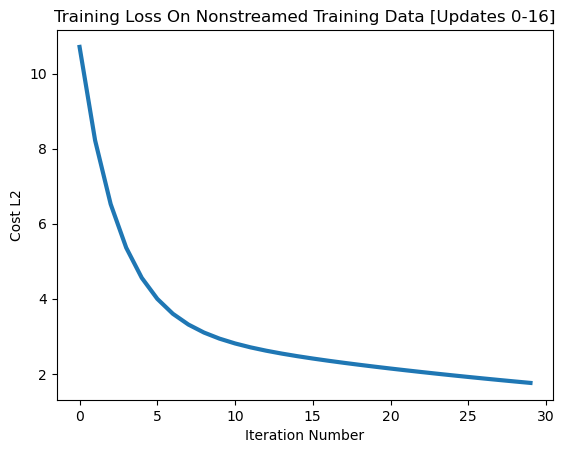

In [17]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, compare_model_and_matmul=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data False
stream_data_updates True
return_cost_func_comps False

v_pred_model shape: torch.Size([1199, 2]);
 vals[:5,:]: tensor([[-0.0214,  0.0636],
        [-0.0214,  0.0636],
        [-0.0214,  0.0636],
        [ 0.2544,  1.1357],
        [ 0.2544,  1.1357]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-15.6642,  -1.2905],
        [-15.6642,  -1.2905],
        [-15.7845,   0.2538],
        [-15.7845,   0.2538],
        [-15.7845,   0.2538]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([1199, 2]);
 vals[:5,:]: tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.2758, 1.0721],
        [0.2758, 1.0721]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-15.6428,  -1.3542],
        [-15.6428, 


v_pred_model shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[-2.4378,  8.6017],
        [-2.3007,  8.0078],
        [ 0.0690,  9.6723],
        [-0.3735,  7.1447],
        [-0.3735,  7.1447]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[ 0.6365,  1.7161],
        [-0.4594,  0.9690],
        [-1.3048,  0.7772],
        [-1.3048,  0.7772],
        [ 0.2447, -0.3922]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[-2.4166,  8.5381],
        [-2.2796,  7.9441],
        [ 0.0902,  9.6086],
        [-0.3524,  7.0811],
        [-0.3524,  7.0811]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[ 0.6577,  1.6525],
        [-0.4382,  0.9054],
        [-1.2836,  0.7136],
        [-1.2836,  0.7136],
        [ 0.2659, -0.4558]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul_s shape: torch.Size([1202, 2]);
 vals[:5,:]: tensor([[-2.4166,  8.5381],
        [-2.2796,  7.

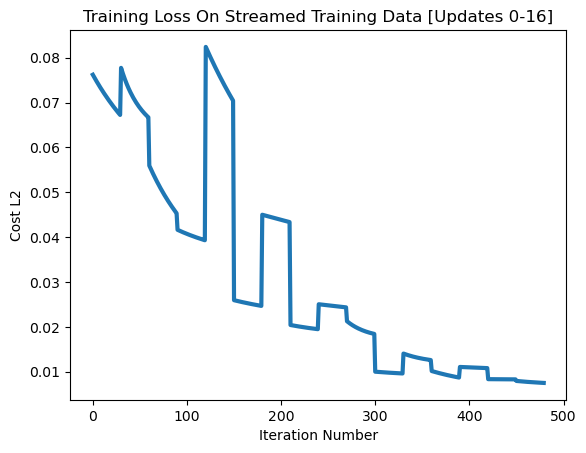

In [18]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, compare_model_and_matmul=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 10
use_full_input_data False
stream_data_updates True
return_cost_func_comps False

v_pred_model shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[-17.7185,   4.2721],
        [-17.7185,   4.2721],
        [-24.1804,   9.6640],
        [-27.2540,  10.4636],
        [-27.2540,  10.4636]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-20.2917,  11.3769],
        [-20.8464,  11.3476],
        [-20.8464,  11.3476],
        [-22.8305,  13.5717],
        [-22.8305,  13.5717]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[-17.7810,   4.2041],
        [-17.7810,   4.2041],
        [-24.2429,   9.5961],
        [-27.3165,  10.3956],
        [-27.3165,  10.3956]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-20.3542,

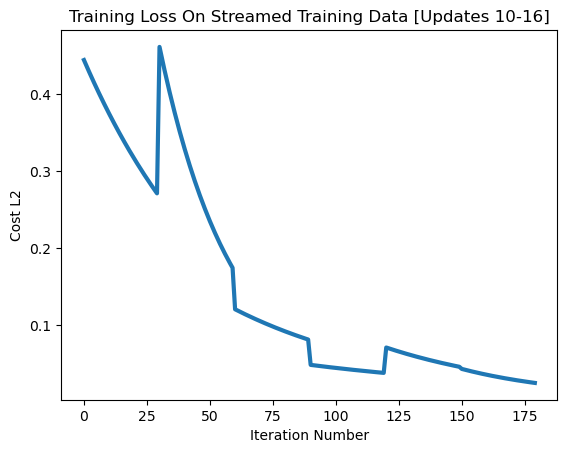

In [19]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2)  # Single layer nn for Lin Regr

trained_model_streamed10, loss_log_streamed10 = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, compare_model_and_matmul=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=10,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_streamed10)), loss_log_streamed10, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 10-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Redoing but turning PyTorch model bias off

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data True
stream_data_updates False
return_cost_func_comps False

v_pred_model shape: torch.Size([19228, 2]);
 vals[:5,:]: tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.5412, -0.5631],
        [-0.5412, -0.5631]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-20.2978,   8.5369],
        [-20.2978,   8.5369],
        [-20.2978,   8.5369],
        [-19.5296,   5.7774],
        [-19.5296,   5.7774]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([19228, 2]);
 vals[:5,:]: tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.5412, -0.5631],
        [-0.5412, -0.5631]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-20.2978,   8.5369],
       

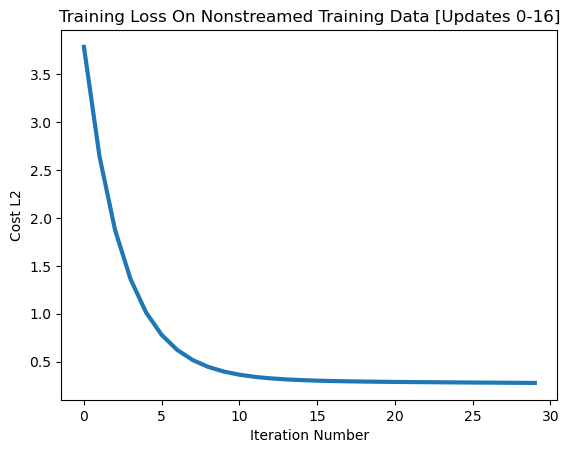

In [20]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2, bias=False)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, compare_model_and_matmul=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=False, use_full_input_data=True, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss On Nonstreamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

full_train_linregr_updates Params:
learning_rate 0.0001
lambdasFDE [0, 1e-10, 1e-06]
use_CPHSLoss False; use_CPHSLoss2 True
normalize_emg False
num_iters_per_update 30
starting_update 0
use_full_input_data False
stream_data_updates True
return_cost_func_comps False

v_pred_model shape: torch.Size([1199, 2]);
 vals[:5,:]: tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.8090, 1.7392],
        [0.8090, 1.7392]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[10.0233, -3.3328],
        [10.0233, -3.3328],
        [10.6416, -2.8425],
        [10.6416, -2.8425],
        [10.6416, -2.8425]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([1199, 2]);
 vals[:5,:]: tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.8090, 1.7392],
        [0.8090, 1.7392]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[10.0233, -3.3328],
        [10.0233, -3.3328],
        [10.6

v_pred_model shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[ 1.2941, -0.0563],
        [ 2.3338, -0.6863],
        [ 1.3157,  6.3564],
        [-0.3378,  4.5652],
        [-0.3378,  4.5652]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-7.2599,  2.5651],
        [-7.6901,  2.6457],
        [-7.6901,  2.6457],
        [-8.8832,  3.2695],
        [-8.8832,  3.2695]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul shape: torch.Size([1201, 2]);
 vals[:5,:]: tensor([[ 1.2941, -0.0563],
        [ 2.3338, -0.6863],
        [ 1.3157,  6.3564],
        [-0.3378,  4.5652],
        [-0.3378,  4.5652]], grad_fn=<SliceBackward0>);
 vals[-5:,:]: tensor([[-7.2599,  2.5651],
        [-7.6901,  2.6457],
        [-7.6901,  2.6457],
        [-8.8832,  3.2695],
        [-8.8832,  3.2695]], grad_fn=<SliceBackward0>)
---------------------------------------
v_pred_matmul_s shape: torch.Size([1202, 2]);
 vals[:5,:]: tensor([[ 1.2941, -0.0563],
        [ 2.3338, -0.6

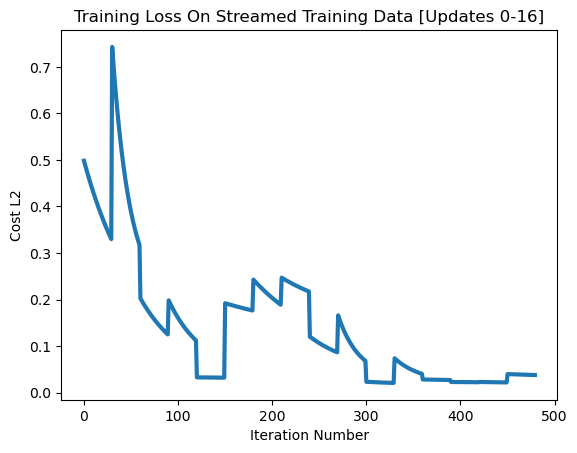

In [21]:
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(64, 2, bias=False)  # Single layer nn for Lin Regr

trained_model_streamed, loss_log_streamed = full_train_linregr_updates(untrained_model_FullData, cli0_cond1_traindata, cli0_cond1_trainlabels, learning_rate, 
                                                                       num_iters_per_update=30, compare_model_and_matmul=True, lambdasFDE=[lambdaF, lambdaD, lambdaE], 
                                                                       stream_data_updates=True, use_full_input_data=False, starting_update=0,
                                                                       use_CPHSLoss2=True)

plt.plot(range(len(loss_log_streamed)), loss_log_streamed, linewidth=3)
plt.title("Training Loss On Streamed Training Data [Updates 0-16]")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()